## Notebook for plotting deployed performance of Chemprop (OOD)

#### Target property: $\sigma_{Li^+}$

**Modified on 14th March, 2023; remodified on 3rd Feb, 2024 (Including Lit OOD)**

**Note: ionic conductivity in common log units**

In [1]:
# import chemprop
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import colorsys
plt.rcParams['font.family'] = 'Arial'
from matplotlib import colors as mc
import matplotlib
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, Descriptors, rdMolDescriptors
import plotly.express as px
import seaborn as sns
# import molplotly

In [2]:
%%bash
pwd   
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/ionic-conductivity_2.1/dataset_v2.0/common-log-output
total 3008
drwx------@ 12 riteshk  staff      384 Jan 18 21:43 x.stratified-split-2-cv
drwx------  20 riteshk  staff      640 Jan 19 23:37 stratified-split-2-cv
drwx------  19 riteshk  staff      608 Jan 24 22:06 cluster-split-2
drwx------  20 riteshk  staff      640 Jan 24 22:07 stratified-split-2
drwxr-xr-x  19 riteshk  staff      608 Jan 24 23:58 stratified-split-1
drwx------  20 riteshk  staff      640 Jan 25 20:55 cluster-split-1
drwx------  15 riteshk  staff      480 Jan 27 08:21 stratified-split-2-cv_2
drwx------  22 riteshk  staff      704 Jan 27 16:16 cdf-stratified-split-2-cv_2
drwx------  37 riteshk  staff     1184 Feb  1 10:08 cdf-random-split
-rw-r--r--   1 riteshk  staff    14746 Feb  3 06:51 cond_ood_final_comp.csv
-rw-r--r--   1 riteshk  staff     7830 Feb  3 06:52 cond_ood_final_add.csv
drwxr-xr-x  24 riteshk  staff     

In [2]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input: color (tuple) in RGB format, amount (float) by which to lighten the color. 
    Returns: (tuple) representing the lightened color in RGB format.
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

color = (0, 0.576, 0.902)
# color_light = (0.9919686274509804, 0.8559372549019608, 0.6511372549019608, 1.0)
lighter_color = lighten_color(color, amount=0.2)

In [3]:
def plot_conductivity_parity(df_pred, figname=None):
    cmap2 = mc.LinearSegmentedColormap.from_list('mycmap', [lighter_color, color])
    norm2 = plt.Normalize(vmin=df_pred["similarity"].min(), vmax=df_pred["similarity"].max())

    axmin = min(min(df_pred['true_conductivity_log']), min(df_pred['conductivity_log'])) - 0.1*(max(df_pred['true_conductivity_log'])-min(df_pred['true_conductivity_log']))
    axmax = max(max(df_pred['true_conductivity_log']), max(df_pred['conductivity_log'])) + 0.1*(max(df_pred['true_conductivity_log'])-min(df_pred['true_conductivity_log']))

    fig, ax = plt.subplots(1,1)
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    # Define a dictionary to map groups to markers
    group_marker_dict = {group: marker for group, marker in zip(df_pred['group'].unique(), ['o', '^'])}

    # Define a dictionary to map classes to sizes
    class_size_dict = {cls: size for cls, size in zip(df_pred['class'].unique(), [50, 100])}

    # Define a dictionary to map sizes to edgecolors
    size_edgecolor_dict = {size: edgecolor for size, edgecolor in zip([50, 100], ['black', 'red'])}

    # Create a new column 'marker' in df_true based on the 'group' column
    df_pred['marker'] = df_pred['group'].map(group_marker_dict)

    # Create a new column 'size' in df_true based on the 'class' column
    df_pred['size'] = df_pred['class'].map(class_size_dict)
    df_pred['edgecolor'] = df_pred['size'].map(size_edgecolor_dict)

    # Create the scatter plot
    for group, marker in group_marker_dict.items():
        df_group = df_pred[df_pred['group'] == group]
        err = ax.errorbar(df_group['true_conductivity_log'], df_pred.loc[df_group.index, 'conductivity_log'], yerr=df_group['conductivity_log_ensemble_uncal_var'], fmt='none', ecolor=color, elinewidth=0.75, capsize=2, zorder=1)
        sc = ax.scatter(df_group['true_conductivity_log'], df_pred.loc[df_group.index, 'conductivity_log'], marker=marker, s=df_group['size'], c=df_group["similarity"], cmap=cmap2, norm=norm2, edgecolors='black', linewidths=0.75, zorder=2)

    # Add colorbar, legend, labels, and other elements as before
    # fig.colorbar(err, ax=ax, ticks=[0.25, 0.50, 0.75, 1.00])
    fig.colorbar(sc, ax=ax, ticks=[0.2, 0.4, 0.6, 0.8, 1.0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('True log $\sigma$ (log mS cm$^{-1}$)')
    plt.ylabel('ML-predicted $\sigma$ (log mS cm$^{-1}$)')
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax.set_aspect('equal')
    at = AnchoredText(
    f"MAE (OOD) = {mae:.2f}\n\nRMSE (OOD) = {rmse:.2f}", prop=dict(size=10), frameon=False, loc='upper left')
    ax.add_artist(at)
    if figname != None:
        plt.savefig(figname, dpi=300)

In [4]:
df_true = pd.read_csv('cond_ood_final_comp.csv')
df_true

,solv_comb_sm,salt_sm,true_conductivity_log,class,group
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house
...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature


In [ ]:
# from electropy.ifg import identify_functional_groups
# def check_carbonate(mol):
#     fgs = identify_functional_groups(mol)
#     for i in range(len(fgs)):
#         if fgs[i].atoms == 'O=C(O)O':
#             return True
#     return False

# classes = {'Carbonate':[], 'Sulfone':[], 'Ether':[], "Esters":[], "Nitriles":[], "Aromatic":[], "Others":[]}
# df_true['class'] = None

# for i in range(len(df_true)):
#     # for j in range(4):
#         if type(df_true['solv_comb_sm'][i]) == float:
#             continue
#         else:
#             mol = Chem.MolFromSmiles(df_true['solv_comb_sm'][i])
#             # if rdMolDescriptors.CalcNumAromaticRings(mol) >= 1:
#             #     classes['Aromatic'].append(df['solv_smiles'][i])
#             #     df['class'][i] = 'Aromatic'
#             if Fragments.fr_sulfone(mol) >= 1: ## calculates only actual sulfones
#                 classes['Sulfone'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Sulfone'
#             elif check_carbonate(mol) == True:
#                 classes['Carbonate'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Carbonate'
#             elif Fragments.fr_ester(mol) >= 1:
#                 classes['Esters'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Esters'
#             elif Fragments.fr_nitrile(mol) >= 1:
#                 classes['Nitriles'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Nitriles'
#             elif Fragments.fr_ether(mol) >= 1:
#                 classes['Ether'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Ether'
#             else:
#                 classes['Others'].append(df_true['solv_comb_sm'][i])
#                 df_true['class'][i] = 'Others'

In [16]:
# df_true['group'] = ['in-house' for i in range(155)] + ['literature' for i in range(155, len(df_true))]
# df_true['class'].unique()

array(['Ether', 'Others'], dtype=object)

In [17]:
# df_true.to_csv('cond_ood_final_comp.csv', index=False)

In [5]:
df_true_add = pd.read_csv('cond_ood_final_add.csv')
df_true_add_rd = pd.read_csv('cond_ood_final_add_rd.csv')
df_true_add

,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,1,0,0,0,270.069064,0,0,0,186.939685,1.0,80
1,1,0,0,0,270.069064,0,0,0,186.939685,1.0,70
2,1,0,0,0,270.069064,0,0,0,186.939685,1.0,60
3,1,0,0,0,270.069064,0,0,0,186.939685,1.0,50
4,1,0,0,0,270.069064,0,0,0,186.939685,1.0,40
...,...,...,...,...,...,...,...,...,...,...,...
166,1,0,0,0,177.991150,0,0,0,186.939685,1.2,25
167,1,0,0,0,177.991150,0,0,0,186.939685,1.0,25
168,1,0,0,0,202.063691,0,0,0,186.939685,1.0,25
169,1,0,0,0,202.063691,0,0,0,186.939685,3.0,25


**Performance of random split models**

In [82]:
## without RDKit features
df_pred_rand_1 = pd.read_csv('./random-split/deploy/final-ood-int-lit/preds_cond_ood_final_ran_comm_s2300_e3.csv')
df_pred_rand_1['group'][154] = 'literature'
df_pred_rand_1

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/3671650849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_rand_1['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.384670,0.002073
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.310923,0.001715
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.237949,0.001769
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.164128,0.001849
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.091989,0.001794
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.069724,0.006179
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.095862,0.006216
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.010850,0.011856
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.116398,0.010380


In [11]:
df_ref = pd.read_csv('../../../red-dim-visualization/IC-data/uniq_solv_smiles_set_random.csv') ## random split train set
ref = df_ref[df_ref['set'].str.contains('train')]['solv_smiles'].tolist()
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

def check_similarity(smile):
    mol = Chem.MolFromSmiles(smile)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_similarity = max(similarity)
    ind = similarity.index(max_similarity)
    sim_smile = ref[ind]
    return max_similarity, ind, sim_smile

In [83]:
similarity_list = []
similar_smiles = []
for i in range(len(df_pred_rand_1)):
    sm = df_pred_rand_1['solv_comb_sm'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_rand_1['similarity'] = similarity_list
df_pred_rand_1['most_similar'] = similar_smiles
df_pred_rand_1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.384670,0.002073,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.310923,0.001715,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.237949,0.001769,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.164128,0.001849,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.091989,0.001794,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.069724,0.006179,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.095862,0.006216,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.010850,0.011856,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.116398,0.010380,0.322581,COC(=O)OCCC(F)(F)F


In [84]:
y_pred = df_pred_rand_1['conductivity_log']
y_true = df_pred_rand_1['true_conductivity_log']
y_pred_unc = df_pred_rand_1['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [85]:
df_pred_rand_1['error'] = abs(y_true - y_pred)
df_pred_rand_1['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(df_pred_rand_1.loc[df_pred_rand_1['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_rand_1.loc[df_pred_rand_1['similarity'] <= 0.35]['error_sq'].mean()))

0.4100917633868655
0.6028241123067731


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


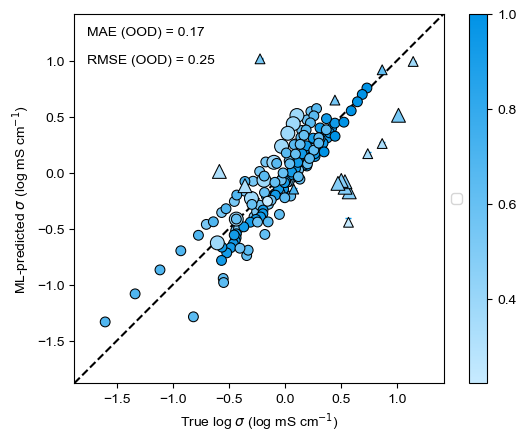

In [124]:
plot_conductivity_parity(df_pred_rand_1, figname=None)

In [50]:
# tt_pred_1 = pd.read_csv('./random-split/deploy/final-ood-int-lit/preds_cond_ood_final_ran_comm_s2300_batch25_e1.csv')
# tt_pred_1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.527492,0.004132
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.471738,0.003113
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.403986,0.003095
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.328604,0.003574
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.240228,0.003970
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.437838,0.004262
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.393844,0.004297
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.310687,0.003897
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.380181,0.021482


In [51]:
# y_pred = tt_pred_1['conductivity_log']
# y_true = tt_pred_1['true_conductivity_log']
# y_pred_unc = tt_pred_1['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


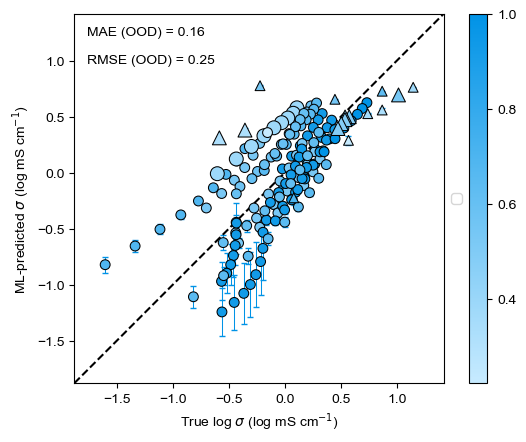

In [117]:
# tt_pred_1['similarity'] = df_pred_rand_1['similarity']
# plot_conductivity_parity(tt_pred_1, figname=None)

In [54]:
# tt_pred_2 = pd.read_csv('./random-split/deploy/final-ood-int-lit/preds_cond_ood_final_ran_comm_s2300_d0.05_e1.csv')
# tt_pred_2['similarity'] = df_pred_rand_1['similarity']
# tt_pred_2

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.496703,0.002339,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.420261,0.003154,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.343633,0.003244,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.276536,0.002971,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.219864,0.002389,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.167921,0.053555,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.217924,0.050284,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.154369,0.035346,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.174550,0.019560,0.322581


In [55]:
# y_pred = tt_pred_2['conductivity_log']
# y_true = tt_pred_2['true_conductivity_log']
# y_pred_unc = tt_pred_2['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


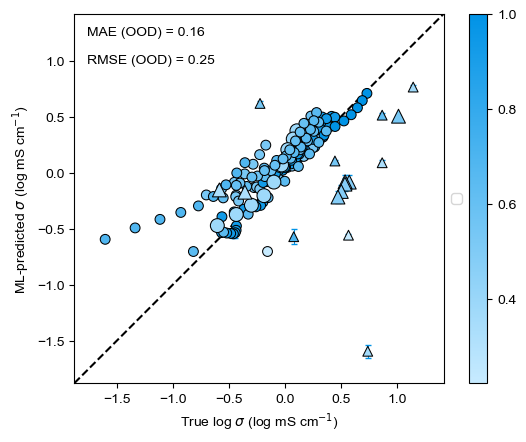

In [118]:
# plot_conductivity_parity(tt_pred_2, figname=None)

In [57]:
# tt_pred_3 = pd.read_csv('./random-split/deploy/final-ood-int-lit/preds_cond_ood_final_ran_comm_s2300_d0.05_m3_e1.csv')
# tt_pred_3['similarity'] = df_pred_rand_1['similarity']
# tt_pred_3

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.539695,0.002569,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.474549,0.002246,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.407740,0.002076,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.339693,0.002737,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.273840,0.003404,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.184321,0.005973,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.154615,0.008422,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.251509,0.033812,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.240878,0.016992,0.322581


In [62]:
# y_pred = tt_pred_3['conductivity_log']
# y_true = tt_pred_3['true_conductivity_log']
# y_pred_unc = tt_pred_3['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


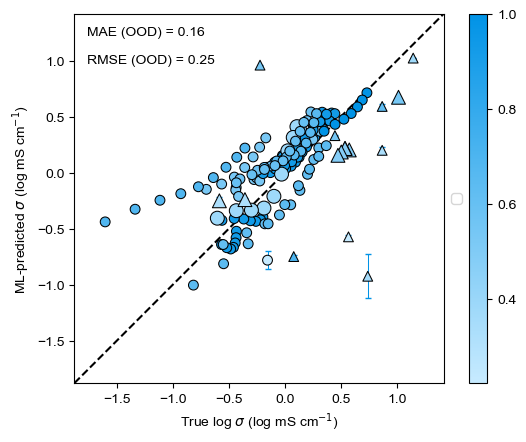

In [119]:
# plot_conductivity_parity(tt_pred_3, figname=None)

In [60]:
# tt_pred_4 = pd.read_csv('./random-split/deploy/final-ood-int-lit/preds_cond_ood_final_ran_comm_s2300_prelu_e1.csv')
# tt_pred_4['similarity'] = df_pred_rand_1['similarity']
# tt_pred_4

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,-2.346003,3.244546,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,-2.504433,3.470638,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,-2.668226,3.692071,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,-2.834951,3.921466,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,-3.006847,4.153153,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-2.833334,3.028898,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-2.957740,3.415203,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-2.991508,3.595262,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-2.182333,1.595944,0.322581


In [65]:
# y_pred = tt_pred_4['conductivity_log']
# y_true = tt_pred_4['true_conductivity_log']
# y_pred_unc = tt_pred_4['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


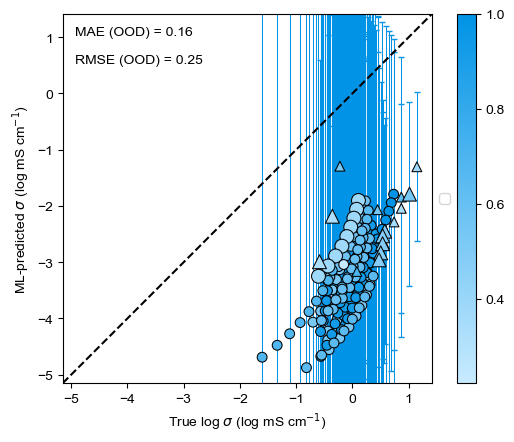

In [120]:
# plot_conductivity_parity(tt_pred_4, figname=None)

**Performance using random split models with RDKit molecular features**

In [17]:
df_pred_rand_2 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s800_e3.csv') # "depth": 3, "dropout": 0.05, "ffn_num_layers": 3, "hidden_size": 800
df_pred_rand_2['group'][154] = 'literature'
df_pred_rand_2['similarity'] = df_pred_rand_1['similarity']
df_pred_rand_2

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/4071608609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_rand_2['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.417682,0.005379,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.360209,0.005319,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.294782,0.005076,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.220428,0.004807,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.134514,0.004592,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.037454,0.010807,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.053036,0.010161,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.202576,0.020393,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.076190,0.055741,0.322581


In [86]:
y_pred = df_pred_rand_2['conductivity_log']
y_true = df_pred_rand_2['true_conductivity_log']
y_pred_unc = df_pred_rand_2['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [87]:
df_pred_rand_2['error'] = abs(y_true - y_pred)
df_pred_rand_2['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(df_pred_rand_2.loc[df_pred_rand_2['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_rand_2.loc[df_pred_rand_2['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_rand_2.loc[df_pred_rand_2['similarity'] < 0.4]['error'].mean()

0.5306103524571152
0.5745886700970233


In [78]:
df_pred_rand_2.loc[df_pred_rand_2['similarity'] <= 0.35]['error'].mean()

0.5052181476209225

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


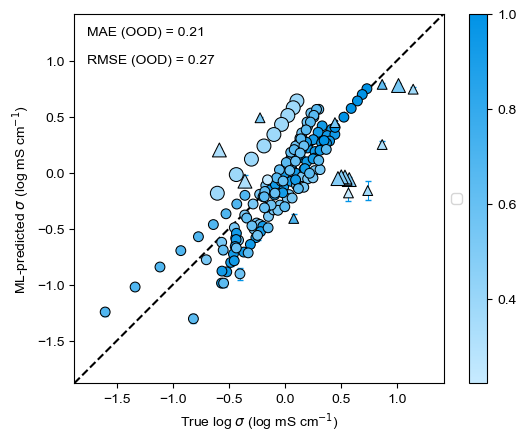

In [186]:
plot_conductivity_parity(df_pred_rand_2, figname=None)

In [128]:
# tt_pred_5 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s600_e3.csv')
# tt_pred_5['similarity'] = df_pred_rand_1['similarity']
# tt_pred_5

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.414526,0.003359,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.359997,0.003723,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.297235,0.004350,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.223940,0.005634,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.136180,0.007473,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.013766,0.023270,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.034226,0.021902,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.275322,0.008514,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.016589,0.029627,0.322581


In [129]:
# y_pred = tt_pred_5['conductivity_log']
# y_true = tt_pred_5['true_conductivity_log']
# y_pred_unc = tt_pred_5['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


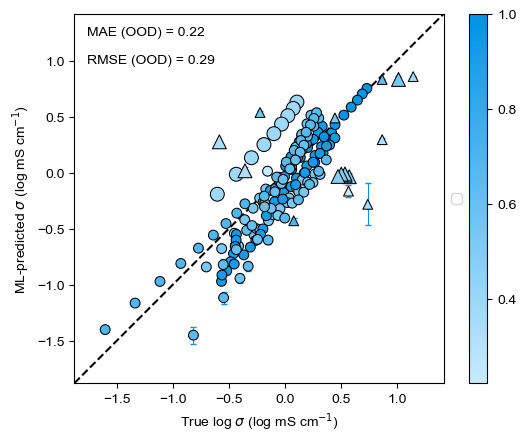

In [130]:
# plot_conductivity_parity(tt_pred_5, figname=None)

In [20]:
tt_pred_6 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s1200_e3.csv')
tt_pred_6['group'][154] = 'literature'
tt_pred_6['similarity'] = df_pred_rand_1['similarity']
tt_pred_6

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/252882351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_pred_6['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.358727,0.008305,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.300380,0.008740,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.233280,0.009147,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.156357,0.009407,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.067557,0.009883,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.039194,0.019929,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.029099,0.019528,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.238663,0.003129,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.069017,0.013903,0.322581


In [88]:
y_pred = tt_pred_6['conductivity_log']
y_true = tt_pred_6['true_conductivity_log']
y_pred_unc = tt_pred_6['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [89]:
tt_pred_6['error'] = abs(y_true - y_pred)
tt_pred_6['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(tt_pred_6.loc[tt_pred_6['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(tt_pred_6.loc[tt_pred_6['similarity'] <= 0.35]['error_sq'].mean()))
# tt_pred_6.loc[tt_pred_6['similarity'] < 0.4]['error'].mean()

0.5124811019244642
0.6529180412693629


In [79]:
tt_pred_6.loc[tt_pred_6['similarity'] <= 0.35]['error'].mean()

0.601226197423884

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


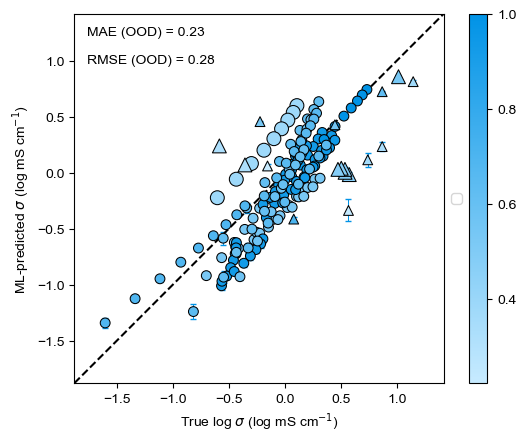

In [90]:
plot_conductivity_parity(tt_pred_6, figname=None)

In [134]:
# tt_pred_7 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s1600_e3.csv')
# tt_pred_7['similarity'] = df_pred_rand_1['similarity']
# tt_pred_7

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.341964,0.003064,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.281226,0.002670,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.212096,0.002432,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.131915,0.002173,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.040787,0.001913,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.001166,0.011448,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.018823,0.011742,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.230767,0.008385,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.057252,0.029209,0.322581


In [135]:
# y_pred = tt_pred_7['conductivity_log']
# y_true = tt_pred_7['true_conductivity_log']
# y_pred_unc = tt_pred_7['conductivity_log_ensemble_uncal_var']

# rmse = mean_squared_error(y_true, y_pred, squared=False)
# mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


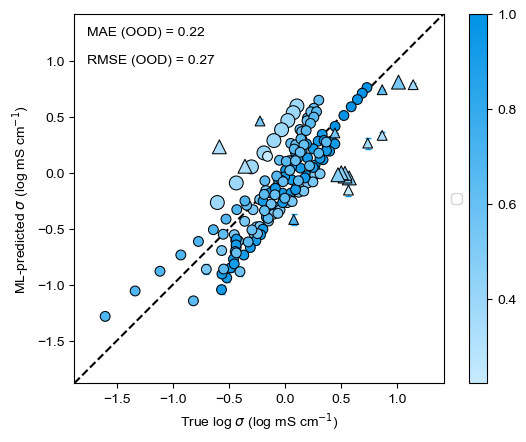

In [136]:
# plot_conductivity_parity(tt_pred_7, figname=None)

In [24]:
tt_pred_8 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s2100_e3.csv')
tt_pred_8['group'][154] = 'literature'
tt_pred_8['similarity'] = df_pred_rand_1['similarity']
tt_pred_8

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/1661931868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_pred_8['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.332962,0.006827,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.274379,0.006591,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.208413,0.006331,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.132415,0.006174,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.044506,0.005999,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.014407,0.013252,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.013132,0.013966,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.220263,0.008800,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.029251,0.024153,0.322581


In [91]:
y_pred = tt_pred_8['conductivity_log']
y_true = tt_pred_8['true_conductivity_log']
y_pred_unc = tt_pred_8['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [92]:
tt_pred_8['error'] = abs(y_true - y_pred)
tt_pred_8['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(tt_pred_8.loc[tt_pred_8['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(tt_pred_8.loc[tt_pred_8['similarity'] <= 0.35]['error_sq'].mean()))
# tt_pred_8.loc[tt_pred_8['similarity'] < 0.4]['error'].mean()

0.4780630905222416
0.6091768952061242


In [80]:
tt_pred_8.loc[tt_pred_8['similarity'] <= 0.35]['error'].mean()

0.5676855054172133

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


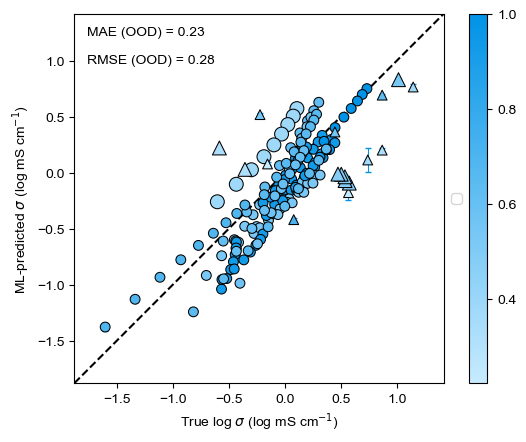

In [27]:
plot_conductivity_parity(tt_pred_8, figname=None)

In [28]:
tt_pred_9 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s2300_e3.csv')
tt_pred_9['group'][154] = 'literature'
tt_pred_9['similarity'] = df_pred_rand_1['similarity']
tt_pred_9

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/1881237540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_pred_9['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.318554,0.006343,0.928571
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.257084,0.006503,0.928571
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.186473,0.006647,0.928571
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.105035,0.007117,0.928571
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.011249,0.007944,0.928571
...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.092630,0.007816,0.481481
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.076505,0.006774,0.481481
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.191544,0.008780,0.322581
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.062992,0.019406,0.322581


In [93]:
y_pred = tt_pred_9['conductivity_log']
y_true = tt_pred_9['true_conductivity_log']
y_pred_unc = tt_pred_9['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [94]:
tt_pred_9['error'] = abs(y_true - y_pred)
tt_pred_9['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(tt_pred_9.loc[tt_pred_9['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(tt_pred_9.loc[tt_pred_9['similarity'] <= 0.35]['error_sq'].mean()))
# tt_pred_9.loc[tt_pred_9['similarity'] < 0.4]['error'].mean()

0.46506397517436376
0.5879661848373677


In [81]:
tt_pred_9.loc[tt_pred_9['similarity'] < 0.35]['error'].mean()

0.5578036435941229

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


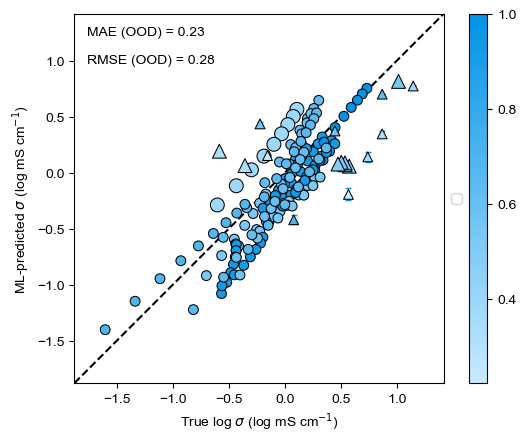

In [31]:
plot_conductivity_parity(tt_pred_9, figname=None)

In [33]:
tt_pred_10 = pd.read_csv('./cdf-random-split/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_ran_comm_s1500_e3.csv')
tt_pred_10['group'][154] = 'literature'
tt_pred_10['similarity'] = df_pred_rand_1['similarity']
tt_pred_10['most_similar'] = df_pred_rand_1['most_similar']
tt_pred_10

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/1225432411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_pred_10['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.342919,0.006443,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.285392,0.006474,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.217787,0.006782,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.140646,0.007108,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.053571,0.007752,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.024796,0.008452,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.024303,0.008156,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.243458,0.005723,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.032530,0.045829,0.322581,COC(=O)OCCC(F)(F)F


In [95]:
y_pred = tt_pred_10['conductivity_log']
y_true = tt_pred_10['true_conductivity_log']
y_pred_unc = tt_pred_10['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [96]:
tt_pred_10['error'] = abs(y_true - y_pred)
tt_pred_10['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(tt_pred_10.loc[tt_pred_10['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(tt_pred_10.loc[tt_pred_10['similarity'] <= 0.35]['error_sq'].mean()))
# tt_pred_10.loc[tt_pred_10['similarity'] < 0.4]['error'].mean()

0.4980054862646478
0.5958775818132098


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


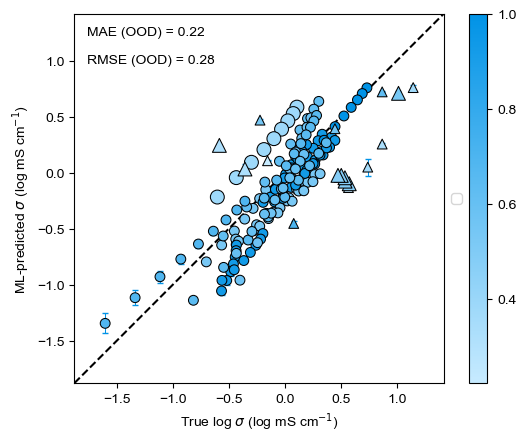

In [36]:
plot_conductivity_parity(tt_pred_10, figname=None)

**Performance of cluster split-I model**

In [89]:
df_pred_clus1 = pd.read_csv('./cluster-split-1/deploy/final-ood-int-lit/preds_cond_ood_final_clus1_comm_s2300_e3.csv')
df_pred_clus1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.510216,0.025881
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.430718,0.034883
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.343948,0.046082
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.246576,0.059112
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.122022,0.069192
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.380289,0.005478
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.356200,0.005891
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.336422,0.009112
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.138117,0.023606


In [90]:
df_ref = pd.read_csv('../../../red-dim-visualization/IC-data/uniq_solv_smiles_set_clus1.csv') ## cluster split train set
ref = df_ref[df_ref['set'].str.contains('train')]['solv_smiles'].tolist()
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_clus1)):
    sm = df_pred_clus1['solv_comb_sm'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_clus1['similarity'] = similarity_list
df_pred_clus1['most_similar'] = similar_smiles
df_pred_clus1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.510216,0.025881,0.315789,COCCOCCOCCOC
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.430718,0.034883,0.315789,COCCOCCOCCOC
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.343948,0.046082,0.315789,COCCOCCOCCOC
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.246576,0.059112,0.315789,COCCOCCOCCOC
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.122022,0.069192,0.315789,COCCOCCOCCOC
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.380289,0.005478,0.148148,CCOC(=O)OCC
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.356200,0.005891,0.148148,CCOC(=O)OCC
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.336422,0.009112,0.173913,COCCOC
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.138117,0.023606,0.173913,COCCOC


In [91]:
y_pred = df_pred_clus1['conductivity_log']
y_true = df_pred_clus1['true_conductivity_log']
y_pred_unc = df_pred_clus1['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


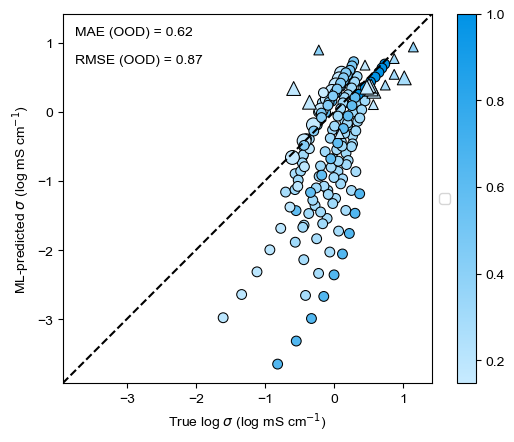

In [92]:
plot_conductivity_parity(df_pred_clus1, figname=None)

**Performance of cluster split-II model**

In [93]:
df_pred_clus2 = pd.read_csv('./cluster-split-2/deploy/final-ood-int-lit/preds_cond_ood_final_clus2_comm_s2300_e3.csv')
df_pred_clus2

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.385334,0.004759
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.311468,0.004153
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.237803,0.003472
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.162991,0.003507
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.083219,0.005437
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.073417,0.011931
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.148441,0.011403
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.034315,0.015941
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.093198,0.028014


In [94]:
df_ref = pd.read_csv('../../../red-dim-visualization/IC-data/uniq_solv_smiles_set_clus2.csv') ## cluster split train set
ref = df_ref[df_ref['set'].str.contains('train')]['solv_smiles'].tolist()
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_clus2)):
    sm = df_pred_clus2['solv_comb_sm'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_clus2['similarity'] = similarity_list
df_pred_clus2['most_similar'] = similar_smiles
df_pred_clus2

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.385334,0.004759,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.311468,0.004153,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.237803,0.003472,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.162991,0.003507,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.083219,0.005437,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.073417,0.011931,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.148441,0.011403,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.034315,0.015941,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.093198,0.028014,0.322581,COC(=O)OCCC(F)(F)F


In [95]:
y_pred = df_pred_clus2['conductivity_log']
y_true = df_pred_clus2['true_conductivity_log']
y_pred_unc = df_pred_clus2['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [ ]:
plot_conductivity_parity(df_pred_clus2, figname=None)

**Performance of stratified split-I model**

In [97]:
df_pred_strat1 = pd.read_csv('./stratified-split-1/deploy/final-ood-int-lit/preds_cond_ood_final_strat1_comm_s2300_e3.csv')
df_pred_strat1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.401248,0.008477
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.329634,0.010255
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.252813,0.012838
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.166189,0.016528
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.068019,0.021700
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.046203,0.016429
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.080922,0.014434
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.039807,0.014202
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.066072,0.019808


In [98]:
df_ref = pd.read_csv('../../../red-dim-visualization/IC-data/uniq_solv_smiles_set_strat1.csv') ## stratified split train set
ref = df_ref[df_ref['set'].str.contains('train')]['solv_smiles'].tolist()
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_strat1)):
    sm = df_pred_strat1['solv_comb_sm'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_strat1['similarity'] = similarity_list
df_pred_strat1['most_similar'] = similar_smiles
df_pred_strat1

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.401248,0.008477,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.329634,0.010255,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.252813,0.012838,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.166189,0.016528,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.068019,0.021700,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.046203,0.016429,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.080922,0.014434,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.039807,0.014202,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,-0.066072,0.019808,0.322581,COC(=O)OCCC(F)(F)F


In [99]:
y_pred = df_pred_strat1['conductivity_log']
y_true = df_pred_strat1['true_conductivity_log']
y_pred_unc = df_pred_strat1['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


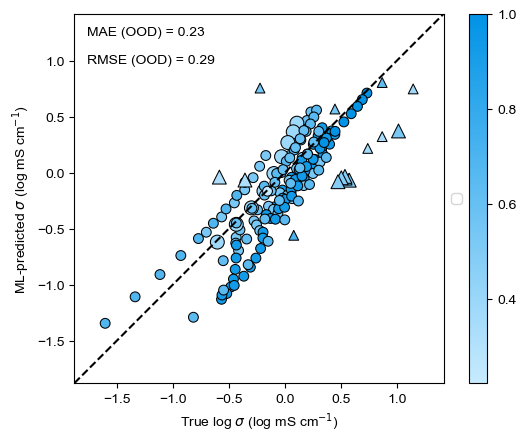

In [100]:
plot_conductivity_parity(df_pred_strat1, figname=None)

**Performance using stratified split-II models**

In [38]:
## without RDKit features
df_pred_strat_2 = pd.read_csv('./stratified-split-2-cv_2/deploy/final-ood-int-lit/preds_cond_ood_final_strat2_cv_comm_s2300_e3.csv')
df_pred_strat_2['group'][154] = 'literature'
df_pred_strat_2

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/3619793843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_strat_2['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.416939,0.001573
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.341271,0.001443
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.262359,0.001473
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.181330,0.001516
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.098997,0.001902
...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.160595,0.012794
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.185616,0.010796
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.039353,0.011571
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.016739,0.011826


In [39]:
df_ref = pd.read_csv('../../../red-dim-visualization/IC-data/uniq_solv_smiles_set_strat2.csv') ## stratified split train set
ref = df_ref[df_ref['set'].str.contains('train')]['solv_smiles'].tolist()
ref_mol = [Chem.MolFromSmiles(sm) for sm in ref]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

similarity_list = []
similar_smiles = []
for i in range(len(df_pred_strat_2)):
    sm = df_pred_strat_2['solv_comb_sm'][i]
    max_similarity, ind, sim_smile = check_similarity(sm)
    # print(sm, max_similarity, sim_smile)
    similarity_list.append(max_similarity)
    similar_smiles.append(sim_smile)
df_pred_strat_2['similarity'] = similarity_list
df_pred_strat_2['most_similar'] = similar_smiles
df_pred_strat_2

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.416939,0.001573,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.341271,0.001443,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.262359,0.001473,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.181330,0.001516,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.098997,0.001902,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.160595,0.012794,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.185616,0.010796,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,-0.039353,0.011571,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.016739,0.011826,0.322581,COC(=O)OCCC(F)(F)F


In [97]:
y_pred = df_pred_strat_2['conductivity_log']
y_true = df_pred_strat_2['true_conductivity_log']
y_pred_unc = df_pred_strat_2['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [98]:
df_pred_strat_2['error'] = abs(df_pred_strat_2['true_conductivity_log'] - df_pred_strat_2['conductivity_log'])
df_pred_strat_2['error_sq'] = (df_pred_strat_2['true_conductivity_log'] - df_pred_strat_2['conductivity_log'])**2
print(np.sqrt(df_pred_strat_2.loc[df_pred_strat_2['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_strat_2.loc[df_pred_strat_2['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_strat_2.loc[df_pred_strat_2['similarity'] < 0.4]['error'].mean()

0.41083666696043575
0.5717208166439611


In [76]:
df_pred_strat_2.loc[df_pred_strat_2['similarity'] <= 0.35]['error'].mean()

0.481397243151995

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


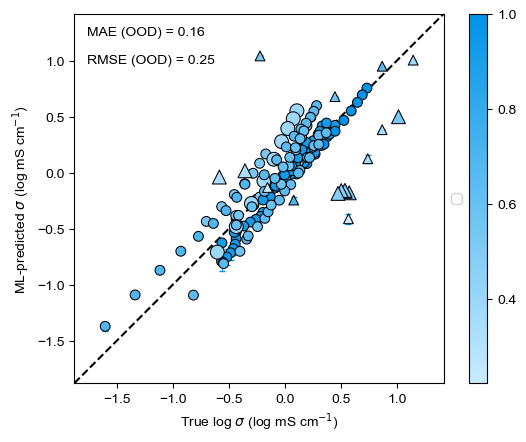

In [42]:
plot_conductivity_parity(df_pred_strat_2, figname=None)

In [43]:
## with RDKit features
df_pred_strat2_2 = pd.read_csv('./cdf-stratified-split-2-cv_2/deploy/final-ood-int-lit/preds_cond_ood_final_cdf_rd_strat2_cv_comm_s800_e3.csv')
df_pred_strat_2['group'][154] = 'literature'
df_pred_strat2_2['similarity'] = df_pred_strat_2['similarity']
df_pred_strat2_2['most_similar'] = df_pred_strat_2['most_similar']
df_pred_strat2_2

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/1429667666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_strat_2['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.397668,0.003130,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.345643,0.003022,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.285295,0.002885,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.215715,0.002844,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.135815,0.002826,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.048418,0.015965,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,0.019113,0.015392,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.326589,0.006349,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.137253,0.051541,0.322581,COC(=O)OCCC(F)(F)F


In [109]:
print(df_pred_strat2_2['group'].unique())
print(df_pred_strat2_2['class'].unique())

['in-house' 'literature']
['Ether' 'Others']


In [106]:
y_pred = df_pred_strat2_2['conductivity_log']
y_true = df_pred_strat2_2['true_conductivity_log']
y_pred_unc = df_pred_strat2_2['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [100]:
# df_pred_strat2_2['error'] = abs(df_pred_strat2_2['conductivity_log'] - df_pred_strat2_2['true_conductivity_log'])
df_pred_strat2_2['error'] = abs(y_true - y_pred)
df_pred_strat2_2['error_sq'] = (y_true - y_pred)**2
print(np.sqrt(df_pred_strat2_2.loc[df_pred_strat2_2['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_strat2_2.loc[df_pred_strat2_2['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_strat2_2.loc[df_pred_strat2_2['similarity'] < 0.4]['error'].mean()

0.5051091415320134
0.5637693086095168


In [73]:
df_pred_strat2_2.loc[df_pred_strat2_2['similarity'] <= 0.35]['error'].mean()

0.5213763795501021

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


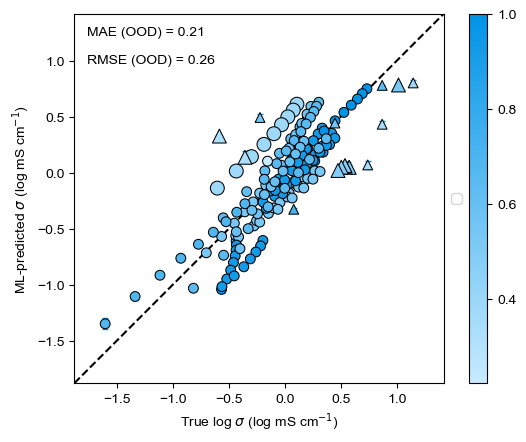

In [107]:
plot_conductivity_parity(df_pred_strat2_2, figname='cond_parity_ood_final_cdf_rd_strat2_cv_comm_s800_e3.eps')

In [47]:
df_pred_strat2_3 = pd.read_csv('./cdf-stratified-split-2-cv_2/deploy/final-ood-int-lit/preds_cond_ood_final_strat2_cv_comm_s1500_e3.csv')
df_pred_strat2_3['group'][154] = 'literature'
df_pred_strat2_3['similarity'] = df_pred_strat_2['similarity']
df_pred_strat2_3['most_similar'] = df_pred_strat_2['most_similar']
df_pred_strat2_3

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/4255395743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_strat2_3['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.326362,0.007258,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.275138,0.007283,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.216379,0.007324,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.150010,0.007413,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.072619,0.007646,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,0.008696,0.015658,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.013447,0.016685,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.293903,0.004704,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.185652,0.026902,0.322581,COC(=O)OCCC(F)(F)F


In [102]:
y_pred = df_pred_strat2_3['conductivity_log']
y_true = df_pred_strat2_3['true_conductivity_log']
y_pred_unc = df_pred_strat2_3['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [103]:
df_pred_strat2_3['error'] = abs(df_pred_strat2_3['conductivity_log'] - df_pred_strat2_3['true_conductivity_log'])
df_pred_strat2_3['error_sq'] = (df_pred_strat2_3['conductivity_log'] - df_pred_strat2_3['true_conductivity_log'])**2
print(np.sqrt(df_pred_strat2_3.loc[df_pred_strat2_3['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_strat2_3.loc[df_pred_strat2_3['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_strat2_3.loc[df_pred_strat2_3['similarity'] < 0.4]['error'].mean()

0.5105903958298175
0.5965369159908286


In [74]:
df_pred_strat2_3.loc[df_pred_strat2_3['similarity'] <= 0.35]['error'].mean()

0.565077252106532

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


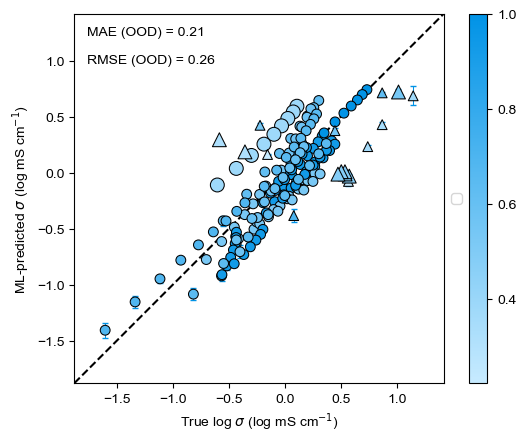

In [50]:
plot_conductivity_parity(df_pred_strat2_3, figname=None)

In [67]:
df_pred_strat2_3.loc[df_pred_strat2_3['similarity'] <= 0.4].sort_values(by='similarity')

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar,error,marker,size,edgecolor
154,C1(OCC(O1)C([F])([F])[F])OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.154902,Ether,literature,0.162033,0.005580,0.222222,CCOC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,0.316935,^,50,black
156,C1C(OCO1)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.568202,Ether,literature,-0.078418,0.036805,0.222222,O=C1OCC(CC(F)(C(F)(F)F)C(F)(F)F)O1,0.646620,^,50,black
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.293903,0.004704,0.322581,COC(=O)OCCC(F)(F)F,0.878930,^,100,red
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.185652,0.026902,0.322581,COC(=O)OCCC(F)(F)F,0.542200,^,100,red
161,COCC(C(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869232,Ether,literature,0.428530,0.020545,0.347826,COCC(F)(F)C(F)(F)COC,0.440702,^,50,black
155,CCOC(OCC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.740363,Ether,literature,0.232305,0.018986,0.357143,CCOCC,0.508058,^,50,black
160,CC(COC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.146128,Ether,literature,0.686189,0.083495,0.375000,COCCOC,0.459939,^,50,black
127,B(OCCF)(OCCF)OCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.107740,Others,in-house,0.593223,0.010564,0.380952,N#CCCOB(OCCC#N)OCCC#N,0.485483,o,100,red
128,B(OCCF)(OCCF)OCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.074800,Others,in-house,0.542040,0.010781,0.380952,N#CCCOB(OCCC#N)OCCC#N,0.467240,o,100,red
129,B(OCCF)(OCCF)OCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.026500,Others,in-house,0.483944,0.010972,0.380952,N#CCCOB(OCCC#N)OCCC#N,0.457444,o,100,red


In [69]:
sim_0_4_ind = df_pred_rand_1.loc[df_pred_rand_1['similarity'] <= 0.4].sort_values(by='similarity')
df_true_add.loc[sim_0_4_ind.index]

,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
154,1,0,0,0,186.050379,0,0,0,186.939685,1.0,25
156,2,0,0,0,142.024164,0,0,0,186.939685,2.0,25
168,1,0,0,0,202.063691,0,0,0,186.939685,1.0,25
169,1,0,0,0,202.063691,0,0,0,186.939685,3.0,25
161,1,0,0,0,158.055464,0,0,0,186.939685,2.0,25
155,1,0,0,0,148.109944,0,0,0,186.939685,1.0,25
160,1,0,0,0,104.083730,0,0,0,186.939685,2.0,25
127,1,0,0,0,200.083159,0,0,0,186.939685,0.8,80
128,1,0,0,0,200.083159,0,0,0,186.939685,0.8,70
129,1,0,0,0,200.083159,0,0,0,186.939685,0.8,60


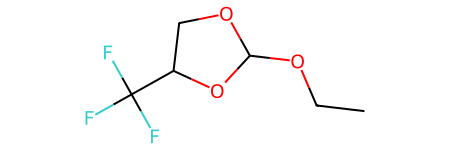

In [65]:
Chem.MolFromSmiles('C1(OCC(O1)C([F])([F])[F])OCC')
# Chem.MolFromSmiles('CCOC(OCC)OCC')
# Chem.MolFromSmiles('COCC(C(F)(F)F)OC')
# Chem.MolFromSmiles('C1C(OCO1)C(F)(F)F')

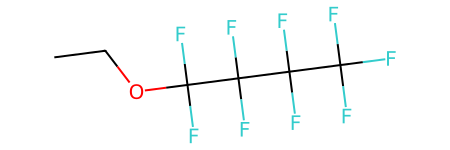

In [66]:
Chem.MolFromSmiles('CCOC(F)(F)C(F)(F)C(F)(F)C(F)(F)F')
# Chem.MolFromSmiles('COCC(F)(F)C(F)(F)COC')
# Chem.MolFromSmiles('O=C1OCC(CC(F)(C(F)(F)F)C(F)(F)F)O1')

In [53]:
df_pred_strat2_3.iloc[154:]

,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar,error,marker,size,edgecolor
154,C1(OCC(O1)C([F])([F])[F])OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.154902,Ether,literature,0.162033,0.005580,0.222222,CCOC(F)(F)C(F)(F)C(F)(F)C(F)(F)F,0.316935,^,50,black
155,CCOC(OCC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.740363,Ether,literature,0.232305,0.018986,0.357143,CCOCC,0.508058,^,50,black
156,C1C(OCO1)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.568202,Ether,literature,-0.078418,0.036805,0.222222,O=C1OCC(CC(F)(C(F)(F)F)C(F)(F)F)O1,0.646620,^,50,black
157,C(CF)OCCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869232,Ether,literature,0.712564,0.007419,0.625000,CCOCCOCCF,0.156668,^,50,black
158,C(CF)OCC(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.447158,Ether,literature,0.375148,0.020571,0.545455,CCOCCOCC(F)F,0.072010,^,50,black
159,C(CF)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.079181,Ether,literature,-0.383679,0.059215,0.705882,FC(F)(F)COCCOCC(F)(F)F,0.462860,^,50,black
160,CC(COC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.146128,Ether,literature,0.686189,0.083495,0.375000,COCCOC,0.459939,^,50,black
161,COCC(C(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869232,Ether,literature,0.428530,0.020545,0.347826,COCC(F)(F)C(F)(F)COC,0.440702,^,50,black
162,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.575188,Others,literature,-0.031020,0.017917,0.481481,CS(=O)(=O)CCOCC(F)(F)F,0.606207,^,100,red
163,CCOS(=O)(=O)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.014940,Others,literature,0.720445,0.028477,0.533333,CCS(C)(=O)=O,0.294496,^,100,red


In [54]:
df_pred_strat2_4 = pd.read_csv('./cdf-stratified-split-2-cv_2/deploy/final-ood-int-lit/preds_cond_ood_final_strat2_cv_comm_s2300_e1.csv')
df_pred_strat2_4['group'][154] = 'literature'
df_pred_strat2_4['similarity'] = df_pred_strat_2['similarity']
df_pred_strat2_4['most_similar'] = df_pred_strat_2['most_similar']
df_pred_strat2_4

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_14372/2120078924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_strat2_4['group'][154] = 'literature'


,solv_comb_sm,salt_sm,true_conductivity_log,class,group,conductivity_log,conductivity_log_ensemble_uncal_var,similarity,most_similar
0,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.333390,Ether,in-house,0.388344,0.001235,0.928571,FC(F)(F)COCCOCC(F)(F)F
1,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.297290,Ether,in-house,0.339136,0.001186,0.928571,FC(F)(F)COCCOCC(F)(F)F
2,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.254010,Ether,in-house,0.281877,0.001075,0.928571,FC(F)(F)COCCOCC(F)(F)F
3,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.202220,Ether,in-house,0.214341,0.000995,0.928571,FC(F)(F)COCCOCC(F)(F)F
4,C(COCCOCCOCC(F)(F)F)(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.137990,Ether,in-house,0.134071,0.001206,0.928571,FC(F)(F)COCCOCC(F)(F)F
...,...,...,...,...,...,...,...,...,...
166,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.503791,Others,literature,-0.020943,0.013674,0.481481,CS(=O)(=O)CCOCC(F)(F)F
167,CS(=O)(=O)OCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.474216,Others,literature,-0.053397,0.011878,0.481481,CS(=O)(=O)CCOCC(F)(F)F
168,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.585027,Others,literature,0.295697,0.005362,0.322581,COC(=O)OCCC(F)(F)F
169,CO[Si](C)(CCC(F)(F)F)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.356547,Others,literature,0.014301,0.032169,0.322581,COC(=O)OCCC(F)(F)F


In [104]:
y_pred = df_pred_strat2_4['conductivity_log']
y_true = df_pred_strat2_4['true_conductivity_log']
y_pred_unc = df_pred_strat2_4['conductivity_log_ensemble_uncal_var']

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae = mean_absolute_error(y_true, y_pred)

In [105]:
df_pred_strat2_4['error'] = abs(df_pred_strat2_4['conductivity_log'] - df_pred_strat2_4['true_conductivity_log'])
df_pred_strat2_4['error_sq'] = (df_pred_strat2_4['conductivity_log'] - df_pred_strat2_4['true_conductivity_log'])**2
print(np.sqrt(df_pred_strat2_4.loc[df_pred_strat2_4['similarity'] < 0.4]['error_sq'].mean()))
print(np.sqrt(df_pred_strat2_4.loc[df_pred_strat2_4['similarity'] <= 0.35]['error_sq'].mean()))
# df_pred_strat2_4.loc[df_pred_strat2_4['similarity'] < 0.4]['error'].mean()

0.5016470439086111
0.5405873060542861


In [75]:
df_pred_strat2_4.loc[df_pred_strat2_4['similarity'] <= 0.35]['error'].mean()

0.4883399901838537

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


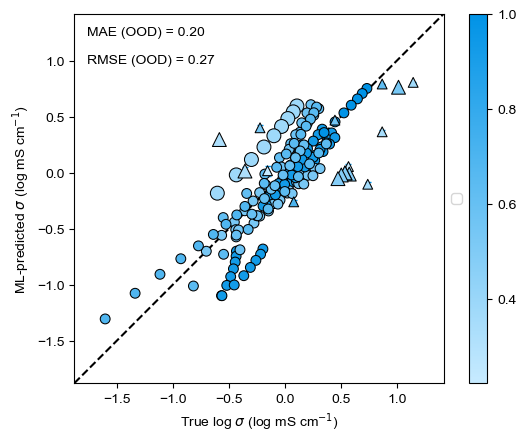

In [57]:
plot_conductivity_parity(df_pred_strat2_4, figname=None)